In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re

def minMaxScale(data, m = None):       
    mini = min(data)
    maxi = max(data)
    
    if (m != None): mini = m
    
    return (data - mini)/(maxi - mini)

In [12]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)

In [13]:
print(len(data), len(data_profit))
display(data.sample(), data_profit.sample())

78684 49058


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj
12913,Eric Idle,M,1943-03-29,Life of Brian,1979.0,20045115.0,94.0,6.75,403154,"[' ""Cult""', ' ""Parody""', ' ""Comedy""}']","[' ""United Kingdom""}']",66817050.0


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
13138,Kevin Clash,M,1960-09-17,Teenage Mutant Ninja Turtles II: The Secret of...,25000000,1991.0,78656813.0,88.0,6.0,56720,"[' ""Japanese Movies""', ' ""Indie""', ' ""Superher...","[' ""United States of America""', ' ""Hong Kong""'...",53656813.0,9.413476e+07


In [16]:
worst_profit = min(data_profit['profit_adj'])
#worst movie
data_profit.query(f'profit_adj == {worst_profit}').sample() #need to adjust budgets for countries
#Here there are issues with the matching of movies & budgets it is matching the budget for the 2005 King Kong movie to the 1933 King Kong 
#movie

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
352,Fay Wray,F,1907-09-15,King Kong,207000000,1933.0,1856000.0,100.0,7.178571,543198,"[' ""Monster movie""', ' ""Horror""', ' ""Adventure...","[' ""United States of America""}']",-205144000.0,-4.102880e+09


In [104]:
#After some research seeing that the largest movie loses aren't over 100 million
movies_profit = data_profit.drop_duplicates(subset = 'Movie_name')
len(movies_profit.query(f'profit_adj <= -100000000'))
#59 movies that lost more than 100 million dollars, we can presume that these are mismatched movies in the budgets
#and there are maybe more than 59

59

In [105]:
print('actor data without the budget ', len(data.drop_duplicates(subset = 'Actor_name')), 'actor data with the budget',  
      len(data_profit.drop_duplicates(subset = 'Actor_name'))) 
print('movie data without the budget ', len(data.drop_duplicates(subset = 'Movie_name')), 'movie data with the budget',  
      len(data_profit.drop_duplicates(subset = 'Movie_name'))) 

actor data without the budget  21924 actor data with the budget 15502
movie data without the budget  7361 movie data with the budget 3610


Because of the mismatched budget data and hard drop off in data points of actors & movies we have decided to calculate for the P2 milestone the star score of our actors without taking into account the budget but we will be using it for further regression analysis

## Observation of distributions

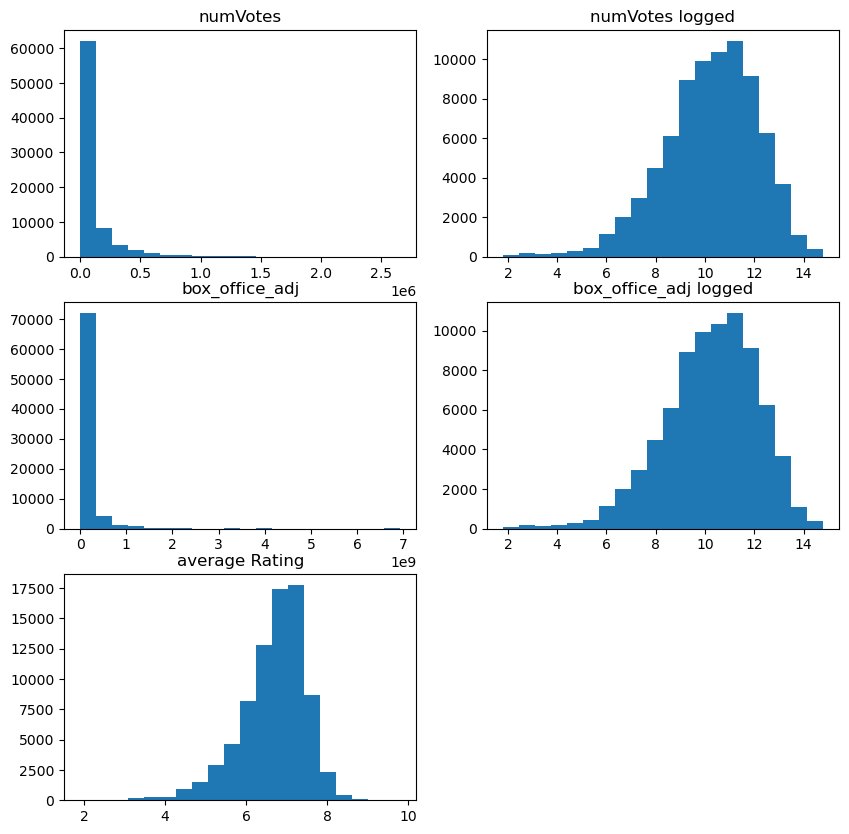

In [106]:
#observation of distributions
fig, ax = plt.subplots(3, 2, figsize=(10, 10)) #sharey=True)

for idx, feature in enumerate(['numVotes', 'box_office_adj']):
    ax[idx, 0].hist(data[feature], bins = 20)
    ax[idx, 0].set_title(feature)
    ax[idx, 1].hist(np.log(data['numVotes']), bins = 20)
    ax[idx, 1].set_title(feature + ' logged')
    
ax[2, 0].hist(data['averageRating'], bins = 20)
ax[2, 0].set_title('average Rating')
ax[2, 1].remove()

plt.show()

# Star score calculation

##### first we need to deflate the imdb ratings by the amount of votes they've gotten

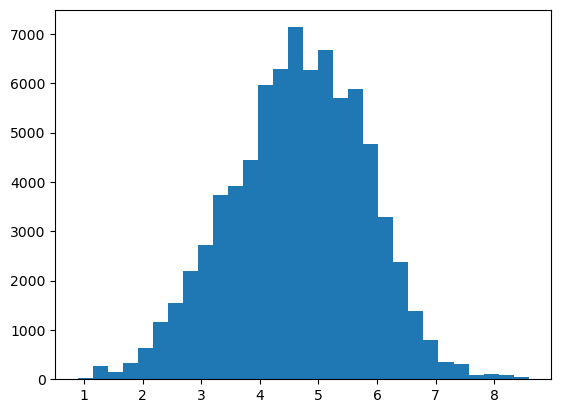

In [107]:
data['numVotes_factor'] = minMaxScale(np.log(data['numVotes']), m = 0)
data['averageRating_adj'] =  data['averageRating']* data['numVotes_factor']
plt.hist(data['averageRating_adj'], bins = 30) #adjusted to the number of votes
plt.show()

## normality tests of our logged box office & our imdb grade dataset
to see if our distributions are log normal and normal 

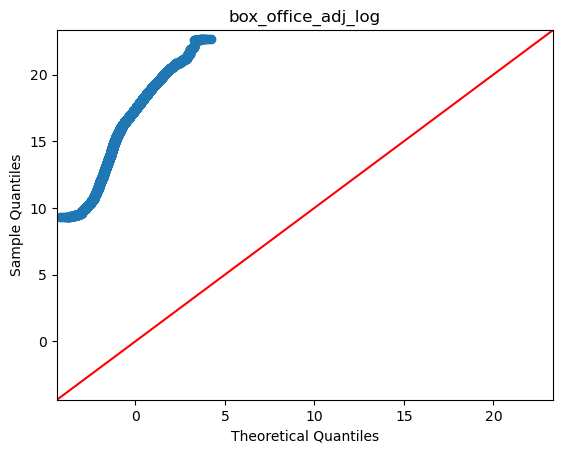

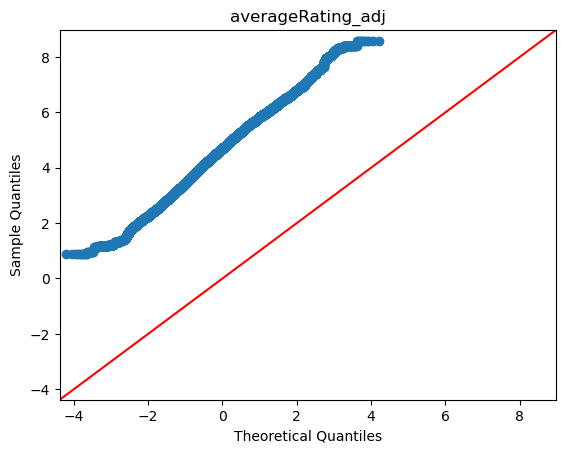

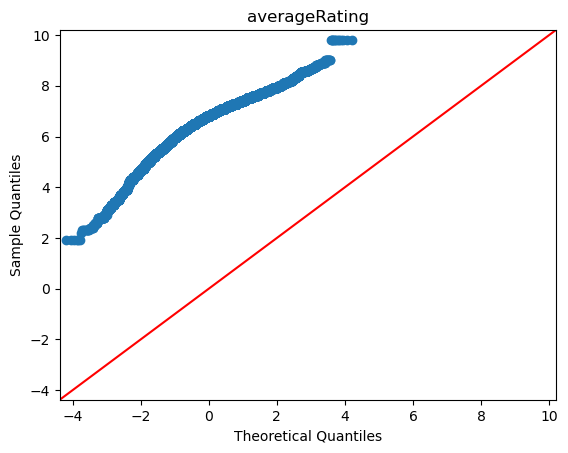

In [108]:
data['box_office_adj_log'] = np.log(data['box_office_adj'])
factors = ['box_office_adj_log', 'averageRating_adj', 'averageRating']

for factor in factors: 
    sm.qqplot(data[factor], line='45')
    plt.title(factor)
plt.show()

In [109]:
from scipy.stats import kstest

for factor in factors: 
    print(factor + ' normality = ', kstest(data[factor], 'norm'))

box_office_adj_log normality =  KstestResult(statistic=1.0, pvalue=0.0)
averageRating_adj normality =  KstestResult(statistic=0.9673502942805045, pvalue=0.0)
averageRating normality =  KstestResult(statistic=0.9976979450558071, pvalue=0.0)


#### Star scores to the latest date of the dataset (milestone P2) will do longitudinal star scores for P3

In [110]:
data['actor'] = data["Actor_name"].apply(lambda x : '_'.join(x.split()))
star_scores = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True))

In [112]:
for idx, actor in enumerate(star_scores['actor']):
    
    ds = data[data['actor'] == actor]
    star_scores.loc[idx, 'rev_sum'] = ds['box_office_adj'].sum()
    star_scores.loc[idx, 'grade_sum'] = ds['averageRating_adj'].sum()
    star_scores.loc[idx, 'appearances'] = len(ds)

In [113]:
star_scores['score'] = np.log(star_scores['rev_sum'] * star_scores['grade_sum'])
star_scores['score_epfl'] = (minMaxScale(star_scores['score']) * 5) + 1
star_scores.head(3)

,actor,rev_sum,grade_sum,appearances,score,score_epfl
0,Dustin_Farnum,6.117500e+06,2.861536,1.0,16.678023,2.697314
1,Elmer_Clifton,1.250000e+09,4.791714,1.0,22.513298,4.217113
2,Robert_Harron,1.250000e+09,4.791714,1.0,22.513298,4.217113


In [114]:
len(star_scores.query('appearances == 1'))/len(star_scores) #48% of actors have 1 movie

0.4836708629812078

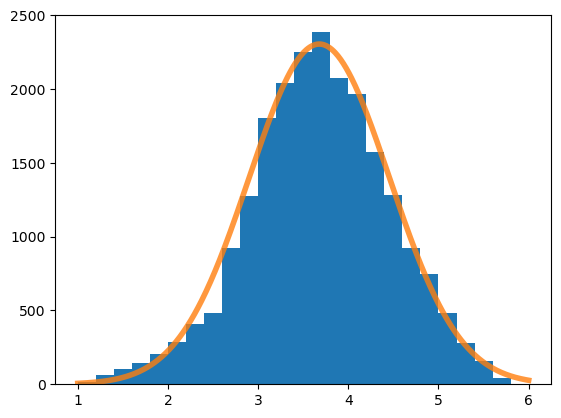

In [158]:
a, loc, std = stats.skewnorm.fit(star_scores['score_epfl'])
rv = stats.skewnorm(a ,loc ,std)
x = np.linspace(1,6, 500)
plt.hist(star_scores['score_epfl'], bins = 25)
plt.plot(x, 4500*rv.pdf(x), lw=4,  alpha = 0.8)
plt.show()

In [159]:
top_actors = star_scores.sort_values(by = 'score_epfl', ascending = False).reset_index(drop = True)
top_actors.head(20)

,actor,rev_sum,grade_sum,appearances,score,score_epfl
0,Samuel_L._Jackson,1.598184e+10,352.123247,69.0,29.358700,6.000000
1,Frank_Welker,1.465697e+10,306.403368,60.0,29.133084,5.941238
2,Tom_Hanks,1.336099e+10,257.706172,46.0,28.867425,5.872047
3,Bruce_Willis,1.003699e+10,308.937981,60.0,28.762683,5.844767
4,Robin_Williams,1.028146e+10,266.290526,52.0,28.638196,5.812345
5,Eddie_Murphy,1.223664e+10,195.184415,44.0,28.501646,5.776780
6,Morgan_Freeman,9.160455e+09,247.529101,48.0,28.449690,5.763248
7,Robert_De_Niro,7.231283e+09,310.554290,58.0,28.440041,5.760735
8,Nicolas_Cage,6.751959e+09,298.582841,59.0,28.332146,5.732634
9,Liam_Neeson,8.091377e+09,246.450570,48.0,28.321226,5.729790


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj,numVotes_factor,averageRating_adj,box_office_adj_log,actor
11574,Maggie Smith,F,1934-12-28,Murder by Death,1976.0,32511047.0,94.0,7.300000,38482,"[' ""Parody""', ' ""Thriller""', ' ""Detective fict...","[' ""United States of America""}']",1.354627e+08,0.713682,5.209877,18.724207,Maggie_Smith
11760,Sigourney Weaver,F,1949-10-08,Annie Hall,1977.0,38251425.0,94.0,8.000000,266022,"[' ""Romantic comedy""', ' ""Comedy of manners""',...","[' ""United States of America""}']",1.530057e+08,0.844372,6.754979,18.845986,Sigourney_Weaver
13129,Drew Barrymore,F,1975-02-22,Altered States,1980.0,19853892.0,104.0,7.475000,36023,"[' ""Science Fiction""', ' ""Horror""', ' ""Surreal...","[' ""United States of America""}']",5.839380e+07,0.709218,5.301406,17.882720,Drew_Barrymore
18668,Kathy Bates,F,1948-06-28,The Morning After,1986.0,25147055.0,103.0,7.094828,15273,"[' ""Thriller""', ' ""Mystery""', ' ""Psychological...","[' ""United States of America""}']",5.466751e+07,0.651215,4.620262,17.816780,Kathy_Bates
21967,Julia Roberts,F,1967-10-28,Mystic Pizza,1988.0,12793213.0,105.0,6.300000,29812,"[' ""Romantic comedy""', ' ""Ensemble Film""', ' ""...","[' ""United States of America""}']",2.610860e+07,0.696426,4.387482,17.077775,Julia_Roberts
30518,Cameron Diaz,F,1972-08-30,The Mask,1994.0,351583407.0,101.0,7.115000,405195,"[' ""Crime Fiction""', ' ""Romance Film""', ' ""Act...","[' ""United States of America""}']",5.670700e+08,0.872816,6.210088,20.155993,Cameron_Diaz


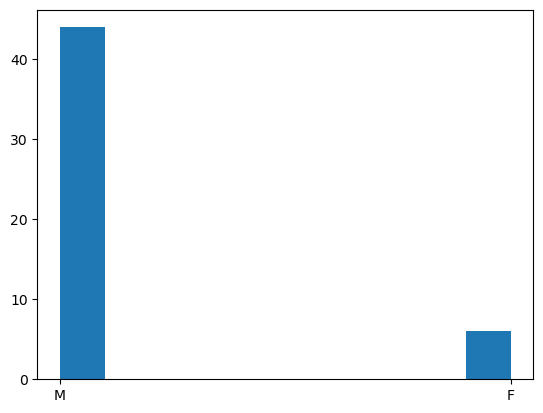

In [166]:
top_actor_data = data[data['actor'].isin(top_actors['actor'].head(50))].drop_duplicates(subset = 'actor')
plt.hist(top_actor_data['Actor_gender'])
top_actor_data.query('Actor_gender == "F"')